# This notebook examines the relative magntidue of horizontal mixing in the native TXLA parent model subsetted to the location of the nested grid

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib inline

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40625 instead
  warnings.warn(


# Open model output with xroms

In [2]:
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

# Source code to get $K_h$ is in 'ini_hmixcoef.F' and 'metrics.F'
# $K_h = (K_{h,0}/max(\sqrt{dxdy})(\sqrt{dxdy})$
    grdscl(i,j)=SQRT(om_r(i,j)*on_r(i,j)), where 
    om_r(i,j)=1.0_r8/pm(i,j) 
    on_r(i,j)=1.0_r8/pn(i,j)

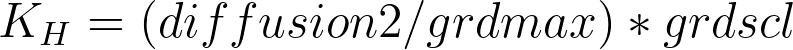

In [3]:
dA = ds_avg.dA
dA_max = (dA**(1/2)).max()
kh_0 = 1.0 #m^2/s
k_h = (kh_0/dA_max)*(dA**(1/2))

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Text(0.5, 1.0, 'Native TXLA: Scaled horizontal diffusion coefficient')

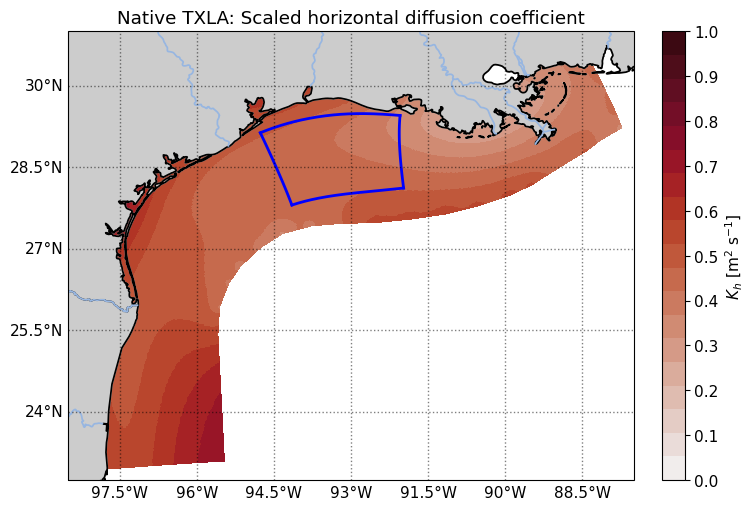

In [4]:
#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

fig, ax = plt.subplots(1, figsize = (8,5), dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

t = k_h.plot(x = 'lon_rho', y = 'lat_rho', cmap = cmo.amp, 
             add_colorbar = False, transform = ccrs.PlateCarree(), 
             vmin = 0, vmax = 1, levels = 20)
ticks = np.arange(0,1.1,0.1)
cb = fig.colorbar(t, ax = ax, label = '$K_h$ [m$^2$ s$^{-1}$]', ticks = ticks)

ax.plot(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)[-1,:], ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)[-1,:], 'b', lw=2,transform = ccrs.PlateCarree())
ax.plot(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)[0,:], ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)[0,:], 'b', lw=2,transform = ccrs.PlateCarree())
ax.plot(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)[:,0], ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)[:,0], 'b', lw=2,transform = ccrs.PlateCarree())
ax.plot(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)[:,-1], ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)[:,-1], 'b', lw=2,transform = ccrs.PlateCarree())

ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.25)
ax.coastlines(resolution='10m', linewidth = 1.25)  
ax.add_feature(cfeature.BORDERS, linewidth=1.25)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.25)
ax.set_aspect('auto')


gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.set_title('Native TXLA: Scaled horizontal diffusion coefficient')
# plt.savefig('/d2/home/dylan/JAMES/figures/Kh_coefficient.jpg', dpi = 300, bbox_inches="tight")  

# Calculate the horizontal salinity gradients and salinity perturbation gradients 

In [7]:
dsaltdxi, dsaltdeta = xroms.hgrad(ds_avg.salt, grid_avg)
dsdx_rho = grid_avg.interp(xroms.to_rho(dsaltdxi, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsdy_rho = grid_avg.interp(xroms.to_rho(dsaltdeta, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsdx_rho.attrs = ''
dsdy_rho.attrs = ''

dV = ds_avg.dV.isel(eta_rho = etaslice, xi_rho = xislice)
V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
salt = ds_avg.salt.isel(eta_rho = etaslice, xi_rho = xislice)
sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])

sprime = ds_avg.salt-sbar
sprime.name = 'sprime'

dsaltprimedxi, dsaltprimedeta = xroms.hgrad(sprime, grid_avg)
dsprimedx_rho = grid_avg.interp(xroms.to_rho(dsaltprimedxi, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsprimedy_rho = grid_avg.interp(xroms.to_rho(dsaltprimedeta, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsprimedx_rho.attrs = ''
dsprimedy_rho.attrs = ''

In [9]:
k_h_slice  = k_h.isel(eta_rho = etaslice, xi_rho = xislice)
chi_horz = 2*(((k_h_slice*(dsprimedx_rho**2)+k_h_slice*(dsprimedy_rho**2))*dV).sum(['eta_rho', 'xi_rho', 's_rho']))

print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    chi_horz_sel = chi_horz.sel(ocean_time = str(dates[d]))
    chi_horz_sel.attrs = ''
    path = '/d2/home/dylan/JAMES/budget_outputs/mixing/chi_horizontal_parent_2010_%s.nc' %d
    chi_horz_sel.name = 'chi_horizontal'
    chi_horz_sel.to_netcdf(path, mode = 'w')

saving outputs


In [23]:
#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

dV = ds_avg.dV.isel(eta_rho = etaslice, xi_rho = xislice)
V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])

dsaltdxi, dsaltdeta = xroms.hgrad(ds_avg.salt, grid_avg)
dsdx_rho = grid_avg.interp(xroms.to_rho(dsaltdxi, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsdy_rho = grid_avg.interp(xroms.to_rho(dsaltdeta, grid_avg), 'Z').isel(eta_rho = etaslice, xi_rho = xislice)
dsdx_rho.attrs = ''
dsdy_rho.attrs = ''

k_h_slice  = k_h.isel(eta_rho = etaslice, xi_rho = xislice)
chi_horz = 2*(((k_h_slice*(dsdx_rho**2)+k_h_slice*(dsdy_rho**2))*dV).sum(['eta_rho', 'xi_rho', 's_rho']))

print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    chi_horz_sel = chi_horz.sel(ocean_time = str(dates[d]))
    chi_horz_sel.attrs = ''
    path = '/d2/home/dylan/JAMES/budget_outputs/mixing/chi_horizontal_parent_nogradient_2010_%s.nc' %d
    chi_horz_sel.name = 'chi_horizontal'
    chi_horz_sel.to_netcdf(path, mode = 'w')

saving outputs


# Next, compute the horizontal diffusion through the lateral boundaries 

In [8]:
sprime2 = sprime**2
dsaltprime2dxi, dsaltprime2deta = xroms.hgrad(sprime2, grid_avg)
dsprime2dx_rho = grid_avg.interp(dsaltprime2dxi, 'Z')
dsprime2dy_rho = grid_avg.interp(dsaltprime2deta, 'Z')

k_h_u = grid_avg.interp(k_h, 'X')
k_h_v = grid_avg.interp(k_h, 'Y')

dxdz = (ds_avg.dx_v*ds_avg.dz_v)
dydz = (ds_avg.dy_u*ds_avg.dz_u)

hdiffusion_u = (k_h_u*dsprime2dx_rho*dydz).isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
hdiffusion_v = (k_h_v*dsprime2dy_rho*dxdz).isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

hdiffW = (hdiffusion_u).isel(xi_u = 0) #West
hdiffE = (hdiffusion_u).isel(xi_u = -1) #East
hdiffN = (hdiffusion_v).isel(eta_v = -1) #North
hdiffS = (hdiffusion_v).isel(eta_v = 0) #South

#Name individual components in case histograms are made, which require the variables be named
hdiffW.name = 'hdiffW'
hdiffE.name = 'hdiffE'
hdiffN.name = 'hdiffN'
hdiffS.name = 'hdiffS'

hdiffds = xr.merge([hdiffW, hdiffE, hdiffN, hdiffS], compat='override')

horz_diffusion = -(hdiffds.hdiffW.sum(['eta_rho', 's_rho'])-hdiffds.hdiffE.sum(['eta_rho', 's_rho']) \
                  +hdiffds.hdiffS.sum(['xi_rho', 's_rho'])-hdiffds.hdiffN.sum(['xi_rho', 's_rho']))

print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    horz_diffusion_sel = horz_diffusion.sel(ocean_time = str(dates[d]))
    horz_diffusion_sel.attrs = ''
    path = '/d2/home/dylan/JAMES/budget_outputs/diffusion/sprime2_horizontal_diffusion_parent_2010_%s.nc' %d
    horz_diffusion_sel.name = 'horizontal_diffusion'
    horz_diffusion_sel.to_netcdf(path, mode = 'w')

saving outputs


In [2]:
#Online numerical mixing
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Horizontal diffusion
path = '/d2/home/dylan/JAMES/budget_outputs/diffusion/sprime2_horizontal_diffusion_parent_2010_*.nc'
horz_diff = xr.open_mfdataset(path).horizontal_diffusion

#Horizontal mixing
path = '/d2/home/dylan/JAMES/budget_outputs/mixing/chi_horizontal_parent_2010_*.nc'
hmix = xr.open_mfdataset(path).chi_horizontal

In [3]:
mres = chi_online+hmix
print(hmix.sum().values/(mres.sum().values))

0.023607029996798153


/tmp/ipykernel_2995/422469277.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation = 0)


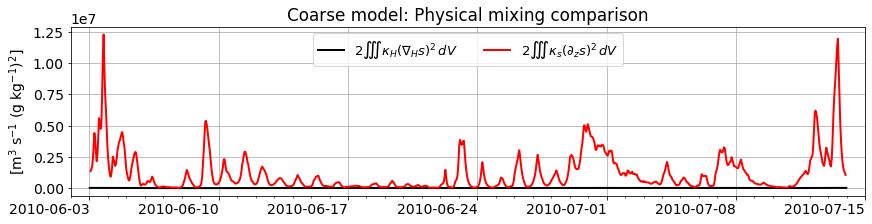

In [4]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,1, figsize = (12,3), constrained_layout = True, sharey = False)

(hmix).plot(lw = 2, color = 'k', label = r'$2\iiint \kappa_H(\nabla_H s)^2 \, dV$')
(chi_online).plot(lw = 2, color = 'r', label = r'$2\iiint \kappa_s(\partial_z s)^2 \, dV$')
ax.legend(ncol = 3, prop={"size":13}, loc = 'upper center')
ax.set_xlabel('')
ax.set_title('Coarse model: Physical mixing comparison')

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
ax.set_xticklabels(dates, rotation = 0)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax.set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax.set_xticks(ticks = dates, rotation = 0)
ax.grid()
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.savefig('/d2/home/dylan/JAMES/figures/draft1/horz_terms_comparison.jpg', dpi = 300, bbox_inches="tight")  

/tmp/ipykernel_18190/2035707983.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(dates, rotation = 0)
/tmp/ipykernel_18190/2035707983.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(dates, rotation = 0)


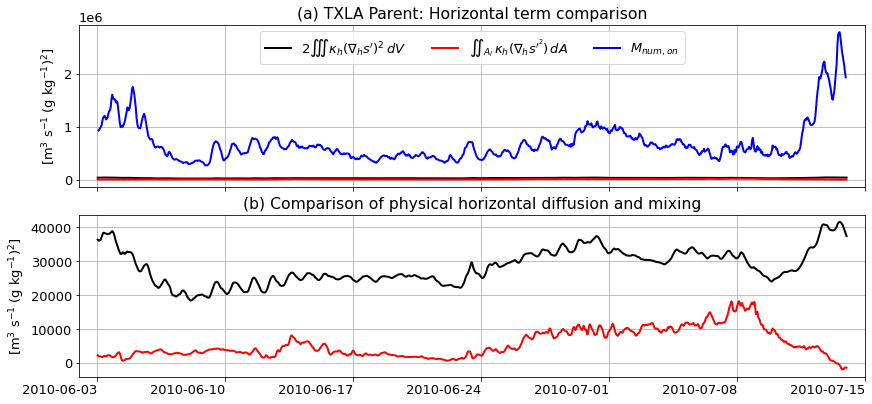

In [16]:
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(2,1, figsize = (12,2.75*2), constrained_layout = True, sharey = False)

hmix.plot(ax = ax[0], lw = 2, color = 'k', label = r'$2\iiint \kappa_h(\nabla_h s^\prime)^2 \, dV$')
horz_diff.plot(ax = ax[0], lw = 2, color = 'r', label = r'$\iint_{A_l} \, \kappa_h(\nabla_h s^{\prime^2}) \, dA$')
mnum_online.plot(ax = ax[0], lw = 2, color = 'b', label = r'$M_{num, on}$')
ax[0].legend(ncol = 3, prop={"size":13}, loc = 'upper center')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[0].set_title('(a) TXLA Parent: Horizontal term comparison')

hmix.plot(ax = ax[1], lw = 2, color = 'k', label = r'$2\iiint \kappa_h(\nabla_h s^\prime)^2 \, dV$')
horz_diff.plot(ax = ax[1], lw = 2, color = 'r', label = r'$\iint_{A_l} \, \kappa_h(\nabla_h s^{\prime^2}) \, dA$')
# ax[1].legend(ncol = 2, prop={"size":13}, loc = 'upper center')
ax[1].set_title('(b) Comparison of physical horizontal diffusion and mixing')
ax[1].set_xlabel('')

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(2):
    ax[i].set_xticklabels(dates, rotation = 0)
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates, rotation = 0)
    ax[i].grid()
ax[0].set_xticklabels([])

plt.savefig('/d2/home/dylan/JAMES/figures/draft1/horz_terms_comparison.jpg', dpi = 300, bbox_inches="tight")  